### Siyu Ma
#### DATA690-08 Financial Data Science
#### Project

This python project aims to predict Netflix stock price based on historical stock price data using Time Series Models.<br>

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 8.9 MB/s 
     |████████████████████████████████| 63 kB 747 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np 
import pandas as pd 
import os
import math
import yfinance as yf
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
warnings.filterwarnings('ignore')

### Import and read data from yahoo finance

In [ ]:
stock = 'NFLX'
start = datetime.datetime(2002,5,23)
end = datetime.datetime(2021,10,20)
nflx = yf.download(stock,start=start,end=end,interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
nflx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [ ]:
nflx.shape

(4887, 6)

In [ ]:
nflx_close = yf.download(stock,start=start,end=end,interval='1d')['Close']

[*********************100%***********************]  1 of 1 completed


In [ ]:
nflx_close.head()

Date
2002-05-23    1.196429
2002-05-24    1.210000
2002-05-28    1.157143
2002-05-29    1.103571
2002-05-30    1.071429
Name: Close, dtype: float64

In [ ]:
nflx_close.describe()

count    4887.000000
mean      106.080998
std       158.057493
min         0.372857
25%         3.907857
50%        21.878571
75%       125.739998
max       639.099976
Name: Close, dtype: float64

### Visualize the Netflix Stock Price 

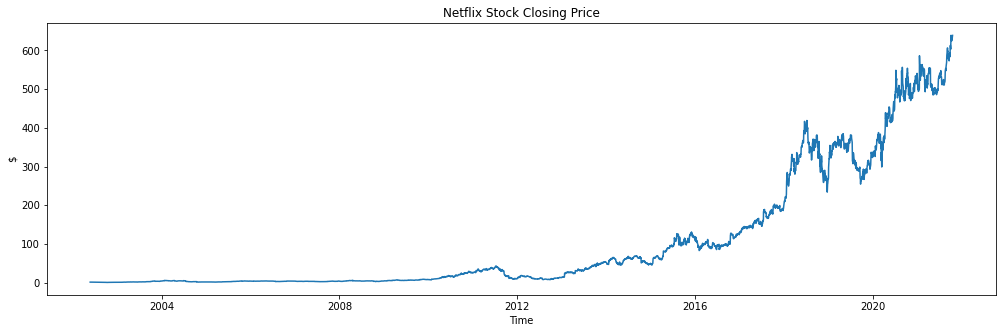

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(nflx_close)
plt.title('Netflix Stock Closing Price')
plt.ylabel('$')
plt.xlabel('Time')
plt.show()

- We can see there is a increasing trend in Netflix'stock price. In 2012, it has a value under $\$100$ USD; And it hits $\$600$ USD in 2021. This trend also indicates the time series is not stationary.


### Check stationarity

#### ADF test

In [ ]:
stat_test = adfuller(nflx_close)[:2]
print('ADF Statistic: %f' % stat_test[0])
print('P-value: %f' % stat_test[1])

ADF Statistic: 3.103854
P-value: 1.000000


- Since the p-value is greater than the significance level(0.05), hence the time series is not stationary. We need to take the first-order difference to check the autocorrelation.

### Autocorrelation Function(ACF)

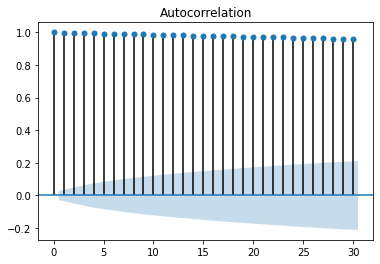

In [ ]:
# acf test
sm.graphics.tsa.plot_acf(nflx_close,lags=30)
plt.show()

- The acf is slowlying decaying, hence the time series is not stationary. So we need to take the first-order differencing.

#### Take the first-order difference

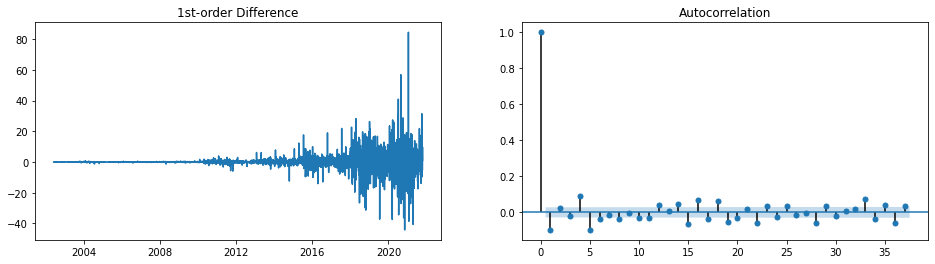

In [ ]:
diff_nflx_close = nflx_close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff_nflx_close)
ax1.set_title('1st-order Difference')
sm.graphics.tsa.plot_acf(diff_nflx_close, ax=ax2);

- After the 1st order differencing, the differenced time series is stationary.

In [ ]:
pip install pmdarima

In [ ]:
from pmdarima.arima.utils import ndiffs

In [ ]:
ndiffs(nflx_close)

2

- From the ndiff module, we double checked that we just need the first difference for our time series data. Hence we get "d = 2".

#### Partial correlation plot

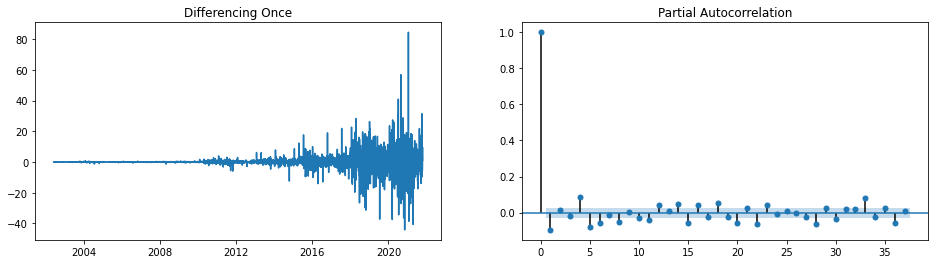

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff_nflx_close)
ax1.set_title('Differencing Once')
sm.graphics.tsa.plot_pacf(diff_nflx_close, ax=ax2)
plt.show()

- The PACF lag 1 is significant because it spikes up over the significant line. Hence, we get "p = 1".

### Use ACF plot to get the parameter for q.
- q is the order of the Moving Average term. 

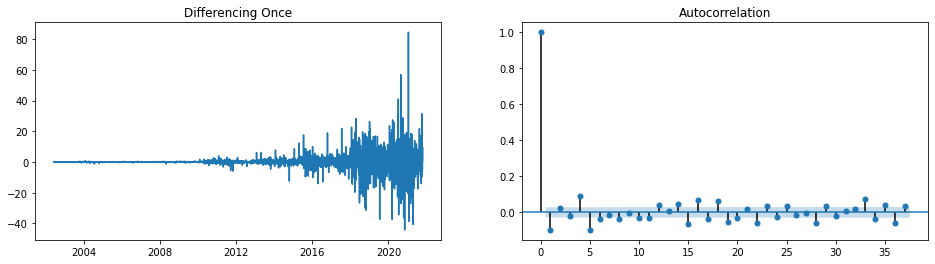

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff_nflx_close)
ax1.set_title('Differencing Once')
sm.graphics.tsa.plot_acf(diff_nflx_close, ax=ax2)
plt.show()

- From the ACF plot, we can choose "q = 2".

### Separating trend and seasonality from the time series for Netflix stock price.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

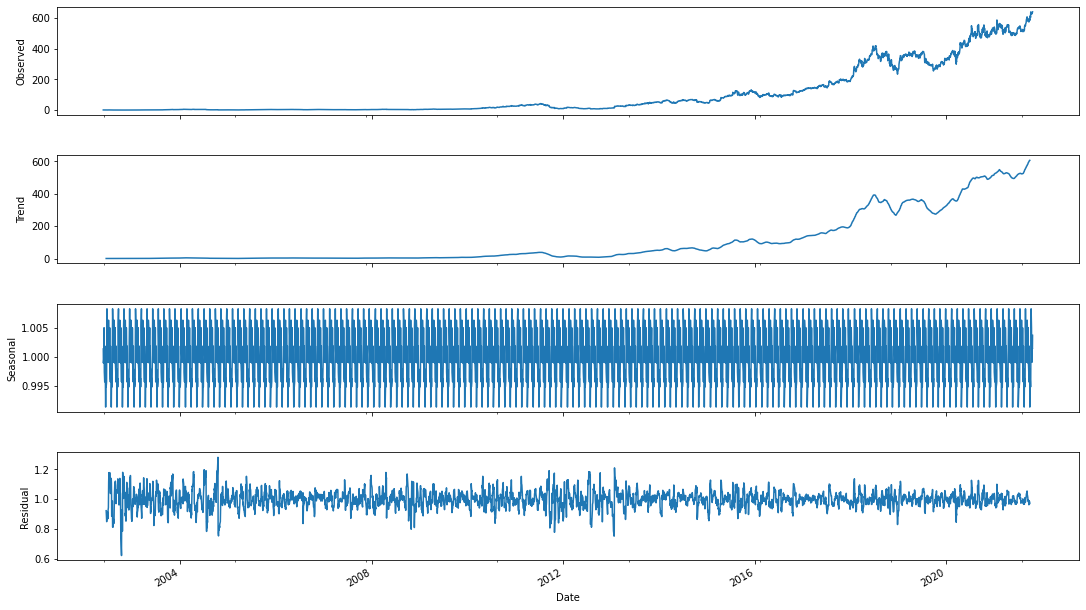

In [ ]:
result = seasonal_decompose(nflx_close, model='multiplicative', freq = 30)
fig = result.plot()  
fig.set_size_inches(17, 10)
plt.show()

- We can see that there is a clear upward trend in the series. And the seasonal change is uniformed. The residuals are not uniformed. Seasonality and residuals are centered at one. 

### Time Series Models

#### Moving Average Model
- Moving average model is often used to capture the time series dynamics by error terms, and MA is always stationary. We need to calculate the first-order difference and drop null values to avoid getting errors.



In [ ]:
diff_nflx_close = nflx_close.diff().dropna()

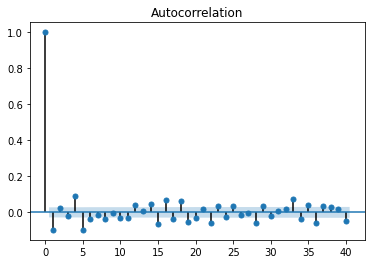

In [ ]:
sm.graphics.tsa.plot_acf(diff_nflx_close,lags=40)
plt.show()

- The ACF plot shows that an MA(5) model might be useful. There are three significant spikes at lag 1, 4, and 5.

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 4886
Model:                     ARMA(0, 5)   Log Likelihood              -14381.770
Method:                       css-mle   S.D. of innovations              4.593
Date:                Tue, 04 Jan 2022   AIC                          28777.539
Time:                        04:04:39   BIC                          28822.998
Sample:                             0   HQIC                         28793.490
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1303      0.058      2.253      0.024       0.017       0.244
ma.L1.Close    -0.0936      0.014     -6.551      0.000      -0.122      -0.066
ma.L2.Close     0.0203      0.014      1.424    

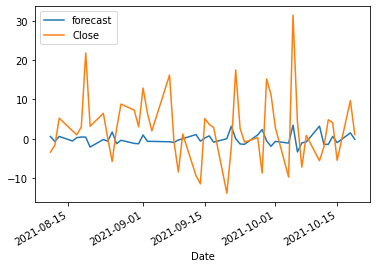

In [ ]:
from statsmodels.tsa.arima_model import ARMA
moving_average_nflx = ARMA(diff_nflx_close, order=(0,5))
result = moving_average_nflx.fit()
print(result.summary())
result.plot_predict(start=4837, end=4885)
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(diff_nflx_close.iloc[4837:4887].values, result.predict(start=4837,end=4885)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 8.979505845011408.


- We can see that the Moving Average model not performance well. From the plot we can see the model over predicted the values.

### Autoregressive Model

---
For Autoregressive models, we need to define the optimal lag number using Partial Autocorrelation Function. 

In [ ]:
from statsmodels.tsa.ar_model import AR

ar_model = AR(diff_nflx_close)
ar_fitted_nflx = ar_model.fit()

In [ ]:
ar_predictions_nflx = ar_fitted_nflx.predict(start=len(diff_nflx_close[:-50]), 
                                   end=len(diff_nflx_close[:-50])+len(diff_nflx_close[-50:])-1,dynamic=False)

- Plot the AR model predictions

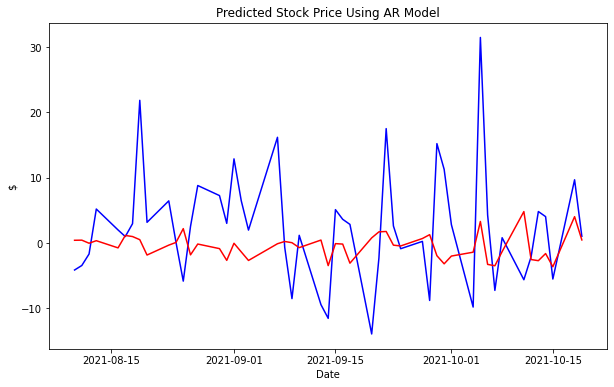

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(diff_nflx_close[-50:], label='Actual Stock Price',c='b')
plt.plot(ar_predictions_nflx,c='r')
plt.title('Predicted Stock Price Using AR Model')
plt.xlabel('Date')
plt.ylabel('$')
plt.show()

- From the plot, we can see that the blue line shows the actual stock prices, red line shows the predictions. The prediction is not very accurate based on the plot.

In [ ]:
rmse = math.sqrt(mean_squared_error(diff_nflx_close[4837:4887], ar_fitted_nflx.predict(start=4837,end=4885)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 8.992190855468738.


### Autoregressive Moving Average(ARMA) Model

In [ ]:
from statsmodels.tsa.arima_model import ARMA
import itertools
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

In [ ]:
p=q=range(0,5)
pq=list(itertools.product(p,q))
arma_results_nflx=[]
for param_set in pq:
    try:
        arma_nflx = ARMA(diff_nflx_close.values,order=param_set)
        arma_fitted_nflx = arma_nflx.fit()
        arma_results_nflx.append(arma_fitted_nflx.aic)
        print('=='*25)
        print('ARMA parameters are:{} & AIC value is:{}'.format(param_set, arma_fitted_nflx.aic))
    except:
        continue
print('**'*25)
print('The Lowest AIC score is {:.4f} and the corresponding parameters are {}'.format(pd.DataFrame(arma_results_nflx).where(pd.DataFrame(arma_results_nflx).T.notnull().all()).min()[0], pq[arma_results_nflx.index(min(arma_results_nflx))]))

ARMA parameters are:(0, 0) & AIC value is:28901.13261423676
ARMA parameters are:(0, 1) & AIC value is:28859.241011373735
ARMA parameters are:(0, 2) & AIC value is:28859.522770921896
ARMA parameters are:(0, 3) & AIC value is:28861.496075471616
ARMA parameters are:(0, 4) & AIC value is:28833.604779151356
ARMA parameters are:(1, 0) & AIC value is:28857.84791579302
ARMA parameters are:(1, 1) & AIC value is:28846.710091691828
ARMA parameters are:(1, 2) & AIC value is:28841.258955932477
ARMA parameters are:(1, 3) & AIC value is:28840.495078287233
ARMA parameters are:(1, 4) & AIC value is:28809.53111253193
ARMA parameters are:(2, 0) & AIC value is:28859.101900398455
ARMA parameters are:(2, 1) & AIC value is:28841.843137530304
ARMA parameters are:(2, 2) & AIC value is:28836.08500566386
ARMA parameters are:(2, 3) & AIC value is:28836.4517247439
ARMA parameters are:(2, 4) & AIC value is:28794.426085610816
ARMA parameters are:(3, 0) & AIC value is:28859.648396625606
ARMA parameters are:(3, 1) & A

In [ ]:
arma_nflx = ARMA(diff_nflx_close, order=(4, 4))
arma_fitted_nflx = arma_nflx.fit()

In [ ]:
arma_predictions_nflx = arma_fitted_nflx.predict(start=len(diff_nflx_close[:-50]), 
                                   end=len(diff_nflx_close[:-50])+len(diff_nflx_close[-50:])-1,dynamic=False)

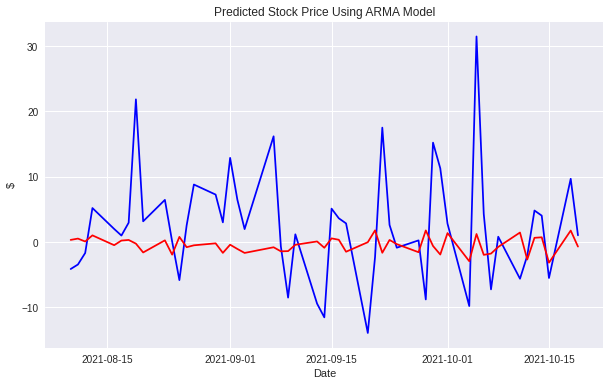

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(diff_nflx_close[-50:], label='Actual Stock Price',c='b')
plt.plot(arma_predictions_nflx,c='r')
plt.title('Predicted Stock Price Using ARMA Model')
plt.xlabel('Date')
plt.ylabel('$')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(diff_nflx_close.iloc[4837:4887].values, arma_fitted_nflx.predict(start=4837,end=4885)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 9.002790352828386.


- From the plot we can see the accuracy is getting better compared to previous models. However, it is not performing a good prediction. 

### Auto-ARIMA model 

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
from itertools import product

In [ ]:
p=q=range(0,5)
d=range(0,3)
pdq=list(product(p,d,q))
arima_result_nflx = []
for param_set in pdq:
  try:
    arima_nflx = ARIMA(diff_nflx_close, order=param_set)
    arima_fitted_nflx = arima_nflx.fit()
    arima_result_nflx.append(arima_fitted_nflx.aic)
    print('=='*25)
    print('ARIMA parameters are:{} & AIC value is:{}'.format(param_set, arima_fitted_nflx.aic))
  except:
    continue
print('**'*25)
print('The lowest AIC score is {:.4f} and the corresponding parameters are {}'.format(pd.DataFrame(arima_result_nflx).where(pd.DataFrame(arima_result_nflx).T.notnull().all()).min()[0],pdq[arima_result_nflx.index(min(arima_result_nflx))]))

ARIMA parameters are:(0, 0, 0) & AIC value is:28901.13261423676
ARIMA parameters are:(0, 0, 1) & AIC value is:28859.241011373735
ARIMA parameters are:(0, 0, 2) & AIC value is:28859.522770921896
ARIMA parameters are:(0, 0, 3) & AIC value is:28861.496075471616
ARIMA parameters are:(0, 0, 4) & AIC value is:28833.604779151356
ARIMA parameters are:(0, 1, 0) & AIC value is:32730.280093916448
ARIMA parameters are:(0, 1, 1) & AIC value is:28901.519784774224
ARIMA parameters are:(0, 2, 0) & AIC value is:38261.33451513873
ARIMA parameters are:(0, 2, 1) & AIC value is:32735.0745673511
ARIMA parameters are:(1, 0, 0) & AIC value is:28857.84791579302
ARIMA parameters are:(1, 0, 1) & AIC value is:28846.710091691828
ARIMA parameters are:(1, 0, 2) & AIC value is:28841.258955932477
ARIMA parameters are:(1, 0, 3) & AIC value is:28840.495078287233
ARIMA parameters are:(1, 0, 4) & AIC value is:28809.53111253193
ARIMA parameters are:(1, 1, 0) & AIC value is:30943.80823276449
ARIMA parameters are:(1, 1, 1) &

- From previous MA result, we know that the time series is not stationary, and so take d = 1 as we can use the first-order difference.

In [ ]:
arima_nflx = ARIMA(nflx_close, order=(3, 2, 1))
arima_fitted_nflx = arima_nflx.fit(transparams=False)

In [ ]:
arima_predictions_nflx = arima_fitted_nflx.predict(start=len(nflx_close[:-50]), 
                                   end=len(nflx_close[:-50])+len(nflx_close[-50:])-1,dynamic=False)

In [ ]:
arima_predictions_nflx = pd.DataFrame(arima_predictions_nflx)
arima_predictions_nflx.index = nflx_close[-50:].index

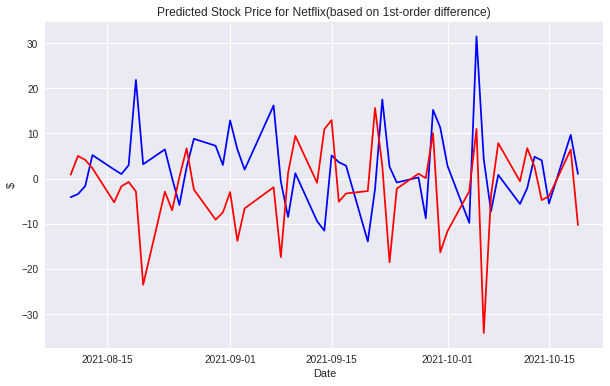

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(diff_nflx_close[-50:], label='Actual Stock Price',c='b')
plt.plot(arima_predictions_nflx,c='r')
plt.title('Predicted Stock Price for Netflix(based on 1st-order difference)')
plt.xlabel('Date')
plt.ylabel('$')
plt.show()

In [ ]:
arima_fitted_nflx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Close   No. Observations:                 4885
Model:                 ARIMA(3, 2, 1)   Log Likelihood              -14423.529
Method:                       css-mle   S.D. of innovations              4.631
Date:                Tue, 04 Jan 2022   AIC                          28859.057
Time:                        04:08:18   BIC                          28898.021
Sample:                             2   HQIC                         28872.729
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0001   4.25e-05      2.530      0.011    2.42e-05       0.000
ar.L1.D2.Close    -0.0957      0.014     -6.691      0.000      -0.124      -0.068
ar.L2.D2.Close     0.0096      0.014      0.665      0.506      -0.019       0.038
ar.L3.D2.Close    -0.0183      0.014     -1.280      0.201      -0.046       0.010
ma.L1.D2.Close    -1.0000      0.001  -1605.933      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.1939           -0.0000j            3.1939           -0.5000
AR.2            1.8579           -3.6934j            4.1344           -0.1758
AR.3            1.8579           +3.6934j            4.1344            0.1758
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
rmse = math.sqrt(mean_squared_error(diff_nflx_close.iloc[4837:4887].values, arima_fitted_nflx.predict(start=4837,end=4885)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 12.236929824745234.


- Based on the AIC and RMS value, Auto-ARIMA Model with order (3, 2, 1) is not performing well. Let's check Seasonal-ARIMA Model.

### SARIMA

In [ ]:
nflx_monthly_close = yf.download(stock, start=start, end=end, interval='1mo')['Close'].dropna()

[*********************100%***********************]  1 of 1 completed


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
s_arima_nflx = auto_arima(nflx_monthly_close,test='adf',
                     d=1,D=1,m=12,error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True,seasonal=True,n_jobs=-1,
                     random_state=20,random=True)

In [ ]:
print(s_arima_nflx.aic())

1884.0799111971473


In [ ]:
s_arima_nflx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  233
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -939.040
Date:                            Tue, 04 Jan 2022   AIC                           1884.080
Time:                                    04:09:19   BIC                           1894.261
Sample:                                         0   HQIC                          1888.191
                                            - 233                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1423      0.039      3.658      0.000       0.066       0.219
ma.S.L12      -0.8622      0.032    -27.114      0.000      -0.924      -0.800
sigma2       277.2112     12.633     21.943      0.000     252.451     301.972
===================================================================================
Ljung-Box (Q):                       95.66   Jarque-Bera (JB):               542.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):            2094.57   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- The result of best model parameter is (0, 1, 0)x(0, 1, 1, 12). And the AIC value is 1870.

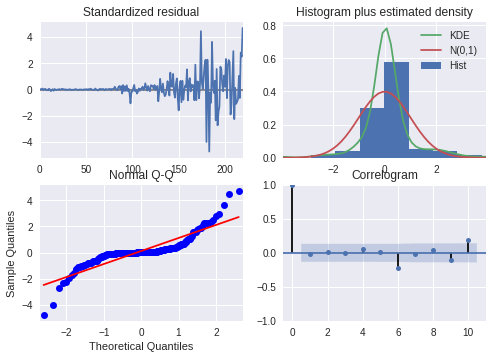

In [ ]:
s_arima_nflx.plot_diagnostics();

In [ ]:
prediction_sarima_nflx = s_arima_nflx.predict(n_periods=50)

In [ ]:
prediction_sarima_nflx = pd.DataFrame(prediction_sarima_nflx)
prediction_sarima_nflx.index = nflx_close[-50:].index

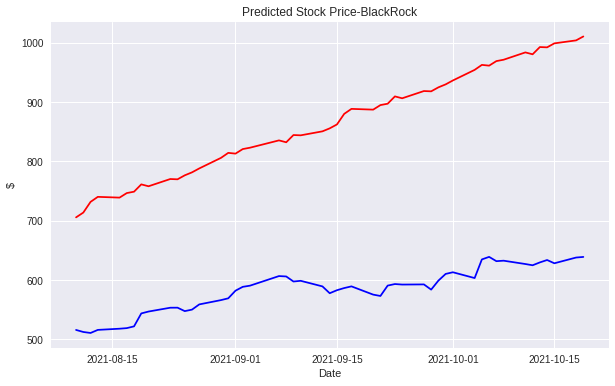

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(nflx_close[-50:], label='Actual Stock Price',c='b')
plt.plot(prediction_sarima_nflx,c='r')
plt.title('Predicted Stock Price-BlackRock')
plt.xlabel('Date')
plt.ylabel('$')
plt.show()

In [ ]:
rmse = math.sqrt(mean_squared_error(nflx_monthly_close[-50:],prediction_sarima_nflx))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 477.95803572749486.


- The results shows that SARIMA model might not be a good model for our time series data.

### Building the final model

- From previous models and testing, I learned that separating the trend and seasonality is critical.

<Figure size 1152x648 with 0 Axes>

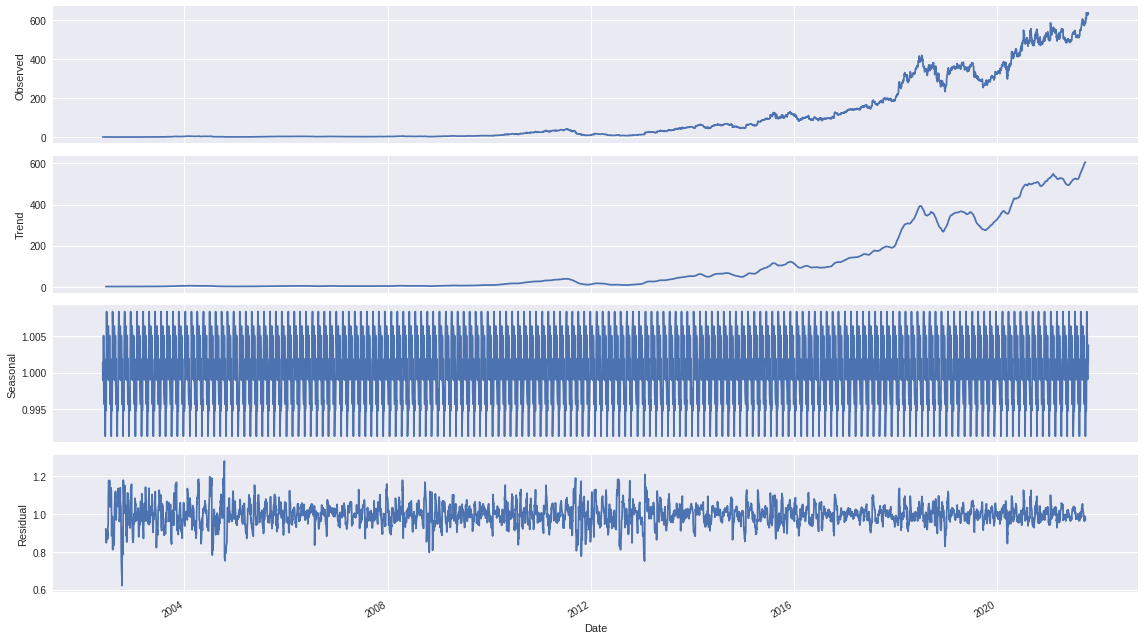

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

res = seasonal_decompose(nflx_close, model='multiplicative', freq=30)
fig = plt.figure()  
fig = res.plot()

- Instead of using the first differencing method, we can try to use the log of the series. It can help with removing trend.
- We could get the rolling average of the series to see the mean consumption values.

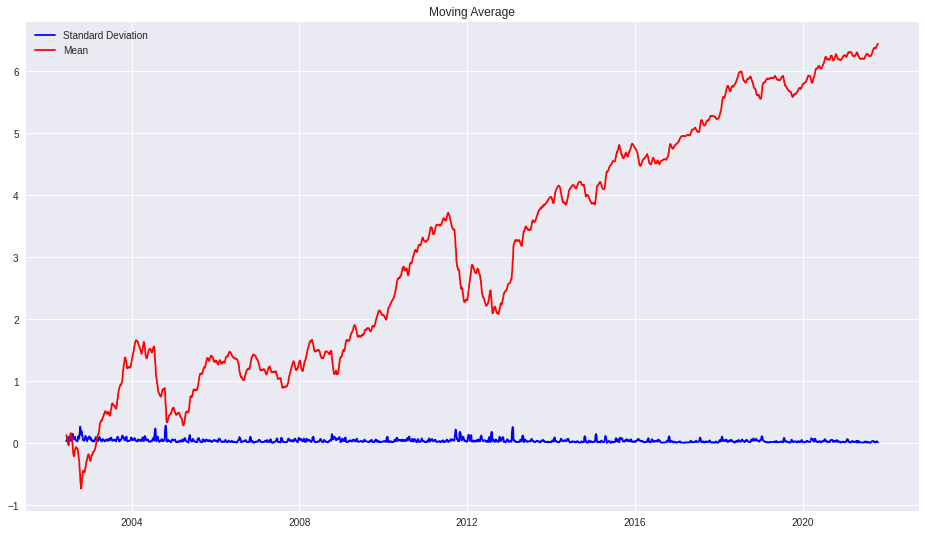

In [ ]:
nflx_log = np.log(nflx_close)

moving_avg = nflx_log.rolling(12).mean()
std_dev = nflx_log.rolling(12).std()

plt.title('Moving Average')
plt.plot(std_dev, color ="b", label = "Standard Deviation")
plt.plot(moving_avg, color="r", label = "Mean")
plt.legend()
plt.show()

Text(0, 0.5, 'price')

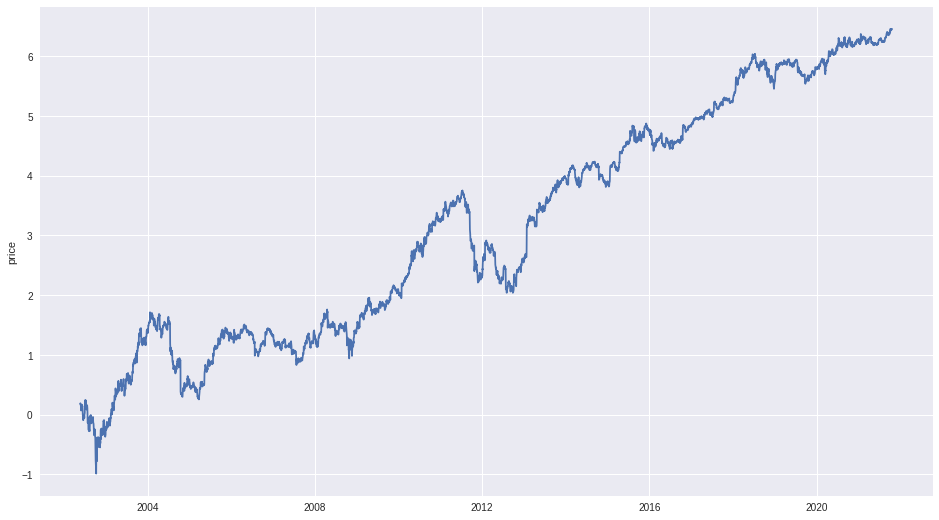

In [ ]:
plt.plot(nflx_log)
plt.ylabel('price')

###  Split the time series data to training and testing set.

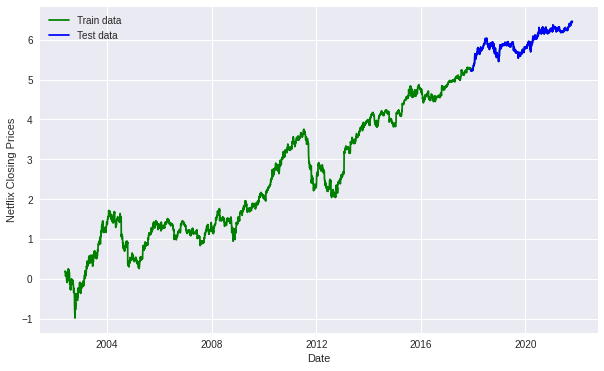

In [ ]:
# split data into train and training set
# training set 80%, testing set 0%

train_data, test_data = nflx_log[1:int(len(nflx_log)*0.8)], nflx_log[int(len(nflx_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Netflix Closing Prices')
plt.plot(nflx_log,'g',label='Train data')
plt.plot(test_data,'b',label='Test data')
plt.legend();


- Now we try the auto arima model again:

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14462.051, Time=1.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14466.182, Time=1.95 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14466.415, Time=4.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14459.538, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14465.875, Time=3.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14465.673, Time=1.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14463.979, Time=3.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-14464.249, Time=0.48 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 16.616 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 3908
Model:               SARIMAX(0, 1, 1)   Log Likelihood                7236.207
Date:                Tue, 04 Jan 2022   AIC                         -14466.415
Time:              

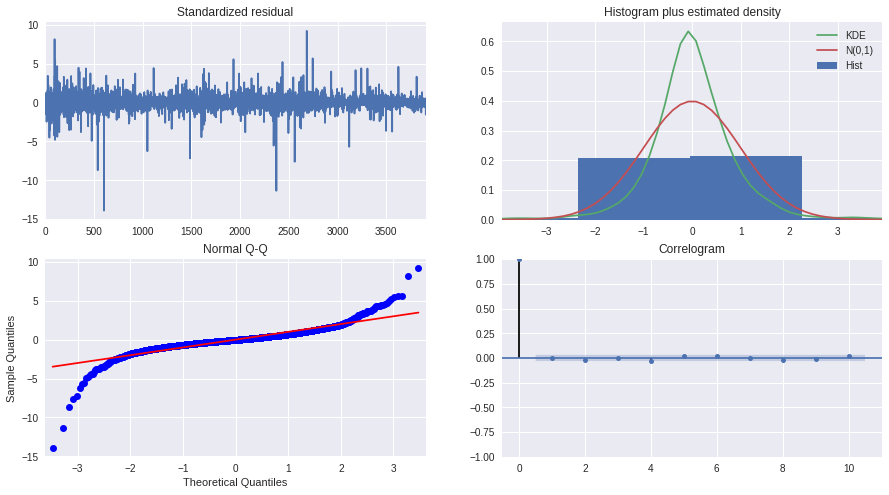

In [ ]:
model_final = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=1,       
                      seasonal=False,trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_final.summary())
model_final.plot_diagnostics(figsize=(15,8))
plt.show()

- From the result, we can see that the residual errors are uniformly fluctuate around mean of zero.
- The normal Q-Q plot shows that the the values are fit with the red line well.
- The densiity histogram shows a normal distribution with mean of zero.
- The ACF plot shows that residuals are not autocorrelated.
- Hence, this is a good model compared to previous models. We can use this model to predict and forecast Netflix's stock price.

### Fit the model 

In [ ]:
model_final_nflx = ARIMA(train_data, order=(0, 1, 1))
model_fitted = model_final_nflx.fit(disp=0)
print(model_fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3907
Model:                 ARIMA(0, 1, 1)   Log Likelihood                7236.207
Method:                       css-mle   S.D. of innovations              0.038
Date:                Tue, 04 Jan 2022   AIC                         -14466.415
Time:                        04:09:44   BIC                         -14447.603
Sample:                             1   HQIC                        -14459.739
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.001      2.041      0.041    5.12e-05       0.003
ma.L1.D.Close     0.0411      0.016      2.526      0.012       0.009       0.073
                                    Root

### Prediction 
- We will use 95% confidence interval in this case.

In [ ]:
fc, se, conf = model_fitted.forecast(978, alpha=0.05)

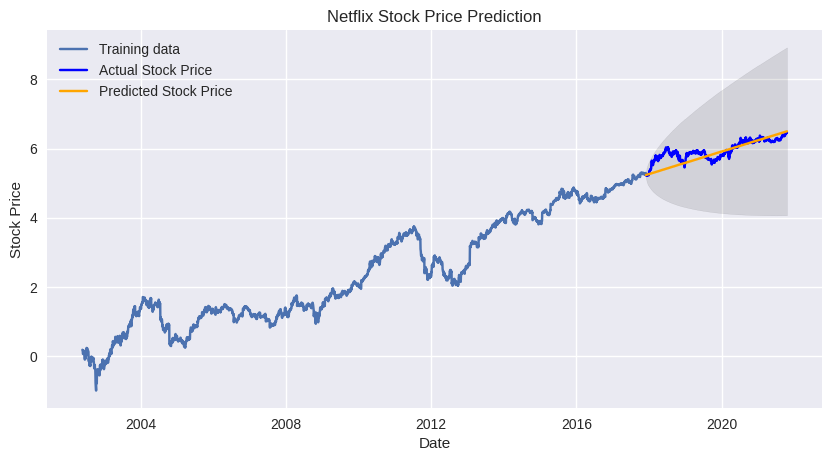

In [ ]:
fitted_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fitted_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Netflix Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.show()

- From the plot we can see that the forecasting data and prediction data are matching.

In [ ]:
mse = mean_squared_error(test_data, fc)
print('MSE: ', mse)

mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE:', mape)

MSE:  0.04787151805831596
MAPE: 0.02841730791577378


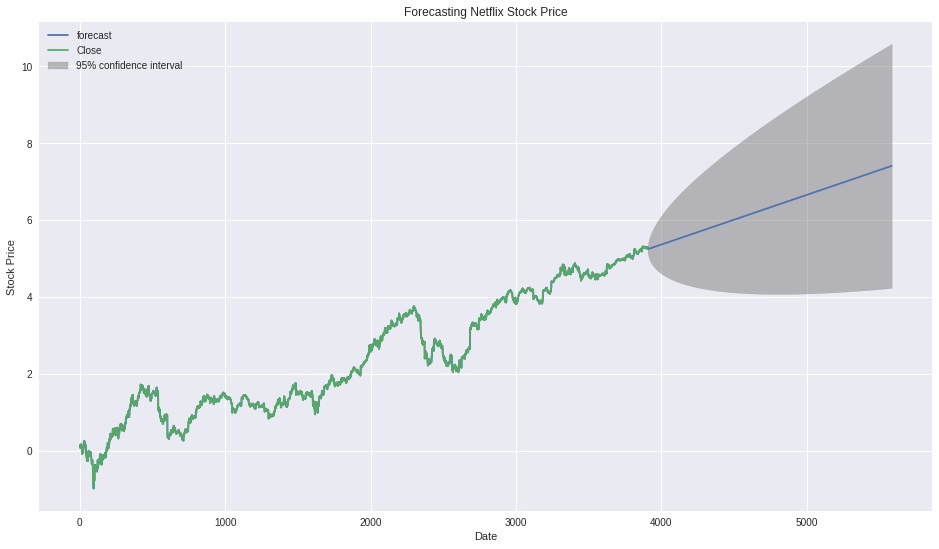

In [ ]:
model_fitted.plot_predict(start=2, end=len(nflx_close)+700)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.title('Forecasting Netflix Stock Price')
plt.show()

- MSE is really small in this case, and MAPE as 2.8% means that 97.2% accurate in predicting the testing data.

### Results and discussion

- From the results, I used ARIMA(0, 1, 1) with constant to predict the Netflix stock price data. The model fit and accuracy showed good feedback. 
- From this project, I realized that those Time Series models we learned from class are mainly used for predicting based on historical data. I have limited time to finish the part for forecasting future stock price. For future study, I will work on testing different models other than time series models on this dataset, and apply other methods to forecast future stock price trend (e.g. machine learning models). <br>